In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# A class created to analyse this tipe of data (uses anndata storege type that mimics phyloseq)
from utils.class_Stastics import Stastics as sc
import numpy as np
from sklearn.utils import resample
from utils import Ancova_analysis
import os
import warnings
warnings.filterwarnings("ignore")


In [292]:
# Charge data
files = os.listdir("data/phyloseq_data")

otu, meta, tax = [pd.read_csv("data/phyloseq_data/" + file,index_col=0) for file in files ]
otu.sum(axis=1).describe()

count      177.000000
mean     54184.858757
std       9651.908704
min      27963.000000
25%      52142.000000
50%      55103.000000
75%      57786.000000
max      83020.000000
dtype: float64

In [293]:
bql = sc(data=otu,metadata=meta)
bql.adata.var=tax
# Filter out unsassigned ASVS
bql.adata = bql.adata[:,(bql.adata.var.Unassigned==False),]
bql.adata.obs["Depth"] = bql.adata.to_df().sum(axis=1)
bql.adata

AnnData object with n_obs × n_vars = 177 × 5099
    obs: 'Bronchiolitis', 'Virus', 'Co-infection', 'Rhinovirus', 'Respiratory syncytial virus', 'Other Viruses', 'Sex (Male)', 'Age', 'Breastfeeding', 'Breastfeeding Duration', 'Family history atopy', 'Passive smoking', 'Wheezing treatment', 'Wheezing count', 'Respiratory hospitalization', 'Asthma treatment', 'Cesarean section', 'Previous antibiotics', 'Fever', 'Hypoxia', 'ICU / High-flow oxygen', 'Hospital stay (days)', 'Wheezing high frequency', 'Age_older', 'Sample_Type', 'Has_pet', 'Pet_type', 'Has_dog', 'Has_cat', 'Depth'
    var: 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Unassigned'
    uns: 'Description_All'

In [294]:
def rarefy_counts(df, depth):
    def rarefy_row(row):
        # Repite cada taxón según su conteo y realiza muestreo aleatorio
        expanded = np.repeat(row.index, row.values)
        rarefied = resample(expanded, n_samples=depth, replace=False, random_state=42)
        return pd.Series(rarefied).value_counts().reindex(row.index, fill_value=0)
    
    # Aplica rarefacción a cada fila
    return df.apply(rarefy_row, axis=1)

min_depth = bql.adata.obs["Depth"].min()
print(min_depth)
rarefied_df = rarefy_counts(bql.adata.to_df(), depth=int(min_depth))
# Rarefaction of counts to 27963
rarefied_df

27963.0


#OTU_num,ASV0,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,...,ASV5392,ASV5393,ASV5396,ASV5397,ASV5399,ASV5402,ASV5404,ASV5406,ASV5407,ASV5408
BQLHLP100ANF,4927,0,0,485,47,0,0,2779,0,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP100GUT,0,0,12404,0,0,0,0,131,5410,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP101ANF,3683,0,0,69,0,0,0,10,0,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP101GUT,0,0,152,0,0,1056,158,0,1080,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP102ANF,9323,16731,0,177,196,0,0,620,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HULP69GUT,0,0,2990,0,0,2533,429,0,980,0,...,0,0,0,0,0,0,0,0,0,0
HULP70ANF,128,0,10,26532,0,0,51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HULP70GUT,0,0,0,0,0,0,16185,16,6333,0,...,0,0,0,0,0,0,0,0,0,0
HULP71ANF,0,0,16676,1,0,0,5054,10,1960,0,...,0,0,0,0,0,0,0,0,0,0


In [295]:
# Save the rarefy counts
bql.adata.X=rarefied_df.to_numpy()

# Calculate the alpha and beta diversity indexes

In [296]:
bql.calc_alpha_div(level="Genus",name="Shannon_index")
bql.calc_beta_div()
os.makedirs("Beta_div",exist_ok=True)
os.makedirs("Beta_div/Distances",exist_ok=True)
bql.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix.csv")
bql.adata.obsm["Distance_matrix"].head()

Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix


,BQLHLP100ANF,BQLHLP100GUT,BQLHLP101ANF,BQLHLP101GUT,BQLHLP102ANF,BQLHLP102GUT,BQLHLP103ANF,BQLHLP103GUT,BQLHLP104ANF,BQLHLP104GUT,...,HULP66GUT,HULP67ANF,HULP68ANF,HULP68GUT,HULP69ANF,HULP69GUT,HULP70ANF,HULP70GUT,HULP71ANF,HULP71GUT
BQLHLP100ANF,0.000000,0.993277,0.815792,0.999821,0.793334,0.996245,0.697529,0.999678,0.893896,0.998856,...,0.999249,0.803741,0.790938,0.992776,0.796803,0.993885,0.976862,0.998391,0.999499,0.977363
BQLHLP100GUT,0.993277,0.000000,0.999571,0.934628,0.995315,0.909201,0.991703,0.493259,0.992240,0.979830,...,0.968065,0.996388,0.990416,0.770268,0.995136,0.806387,0.998927,0.779780,0.463541,0.995709
BQLHLP101ANF,0.815792,0.999571,0.000000,0.999928,0.865358,0.999571,0.884633,0.999928,0.997103,0.999714,...,0.999678,0.865394,0.864964,0.999571,0.865107,0.999928,0.991918,0.999571,0.999535,0.994743
BQLHLP101GUT,0.999821,0.934628,0.999928,0.000000,0.999213,0.963523,0.998176,0.889103,0.999034,0.770447,...,0.946501,0.995995,0.996317,0.894682,0.998927,0.807889,0.997282,0.900404,0.859135,0.998176
BQLHLP102ANF,0.793334,0.995315,0.865358,0.999213,0.000000,0.995351,0.836033,0.999642,0.965168,0.999034,...,0.999070,0.665701,0.640132,0.996102,0.646140,0.999070,0.988842,0.999356,0.998927,0.988556


# Split the data by sample source and case control

In [297]:
bql_anf = bql.filter(var_name="Sample_Type",subgroup=["ANF"],in_place=False)
bql_anf.adata

AnnData object with n_obs × n_vars = 90 × 5099
    obs: 'Bronchiolitis', 'Virus', 'Co-infection', 'Rhinovirus', 'Respiratory syncytial virus', 'Other Viruses', 'Sex (Male)', 'Age', 'Breastfeeding', 'Breastfeeding Duration', 'Family history atopy', 'Passive smoking', 'Wheezing treatment', 'Wheezing count', 'Respiratory hospitalization', 'Asthma treatment', 'Cesarean section', 'Previous antibiotics', 'Fever', 'Hypoxia', 'ICU / High-flow oxygen', 'Hospital stay (days)', 'Wheezing high frequency', 'Age_older', 'Sample_Type', 'Has_pet', 'Pet_type', 'Has_dog', 'Has_cat', 'Depth', 'Shannon_index_level_Genus'
    var: 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Unassigned'
    uns: 'Description_All', 'PCoA_exp_var'
    obsm: 'PCoA', 'Distance_matrix'

In [298]:
bql_gut = bql.filter(var_name="Sample_Type",subgroup=["GUT"],in_place=False)
bql_gut.adata

AnnData object with n_obs × n_vars = 87 × 5099
    obs: 'Bronchiolitis', 'Virus', 'Co-infection', 'Rhinovirus', 'Respiratory syncytial virus', 'Other Viruses', 'Sex (Male)', 'Age', 'Breastfeeding', 'Breastfeeding Duration', 'Family history atopy', 'Passive smoking', 'Wheezing treatment', 'Wheezing count', 'Respiratory hospitalization', 'Asthma treatment', 'Cesarean section', 'Previous antibiotics', 'Fever', 'Hypoxia', 'ICU / High-flow oxygen', 'Hospital stay (days)', 'Wheezing high frequency', 'Age_older', 'Sample_Type', 'Has_pet', 'Pet_type', 'Has_dog', 'Has_cat', 'Depth', 'Shannon_index_level_Genus'
    var: 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Unassigned'
    uns: 'Description_All', 'PCoA_exp_var'
    obsm: 'PCoA', 'Distance_matrix'

In [299]:
# Filter out control data
bql_anf_brq = bql_anf.filter(var_name="Bronchiolitis",subgroup=["Yes"],in_place=False)
bql_gut_brq = bql_gut.filter(var_name="Bronchiolitis",subgroup=["Yes"],in_place=False)

# Figures

In [300]:
# Create the figures directory
os.makedirs("./Figures",exist_ok=True)

## Figure 1

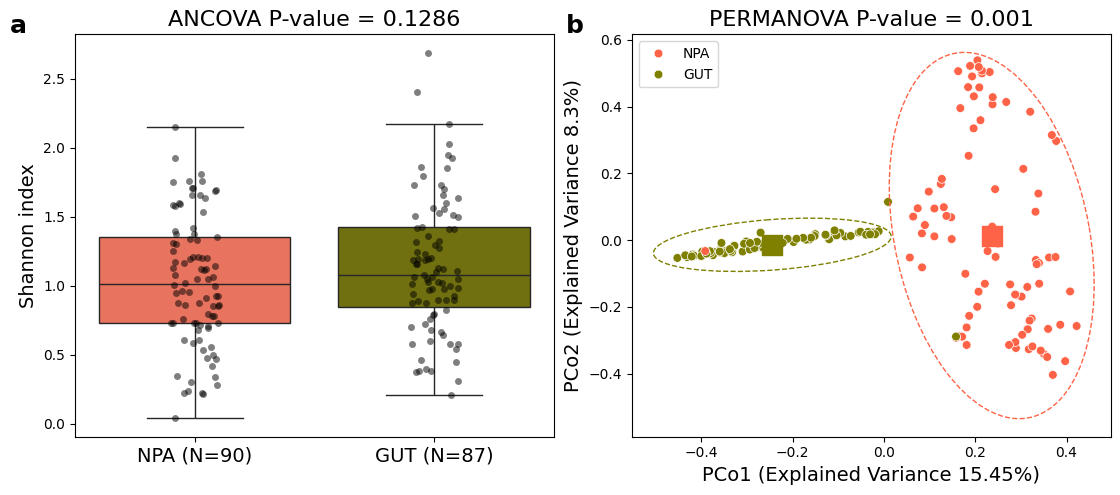

In [301]:
fig,axS = plt.subplots(1,2,figsize=(12,5))

df = bql.find_var(['Shannon_index_level_Genus',"Sample_Type",
                       "Age"]).sort_index()

df.replace({"Sample_Type":{"ANF":"NPA","GUT":"GUT"}},inplace=True)
stype_palette = {"GUT":"olive","NPA":"tomato"}
res, df_anc, ph, ax3 = Ancova_analysis.do_ancova(df,categories=1, plot=True,  ax=axS[0], palette=stype_palette)
ax3.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax3.set_ylabel("Shannon index", fontsize=14)
ax3.set_xticklabels(["NPA (N=90)","GUT (N=87)"],fontsize=14)

df_anc.sort_values(by="PR(>F)", ascending=False)

# Start with the Fig 1 B , beta div
bql.adata.obs["Sample_Type"]= bql.adata.obs["Sample_Type"].replace({"ANF":"NPA","GUT":"GUT"})

bql.plot_pcoa(obsm_key="PCoA",condition_name="Sample_Type",show=False,exp_var=bql.adata.uns["PCoA_exp_var"],
               ax=axS[1],palette=stype_palette)

axS[1].set_title(f"PERMANOVA P-value = 0.001", fontsize=16)
axS[1].set_xlabel(axS[1].get_xlabel(), fontsize=14)
axS[1].set_ylabel(axS[1].get_ylabel(), fontsize=14)
axS[1].legend()

# Add annotations for subplots
axS[0].text(-0.1, 1.05, "a", transform=axS[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[1].text(-0.1, 1.05, "b", transform=axS[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

plt.savefig("Figures/FIGURE_1.svg", bbox_inches="tight")
plt.show()



# Figure 2

Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix
Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix


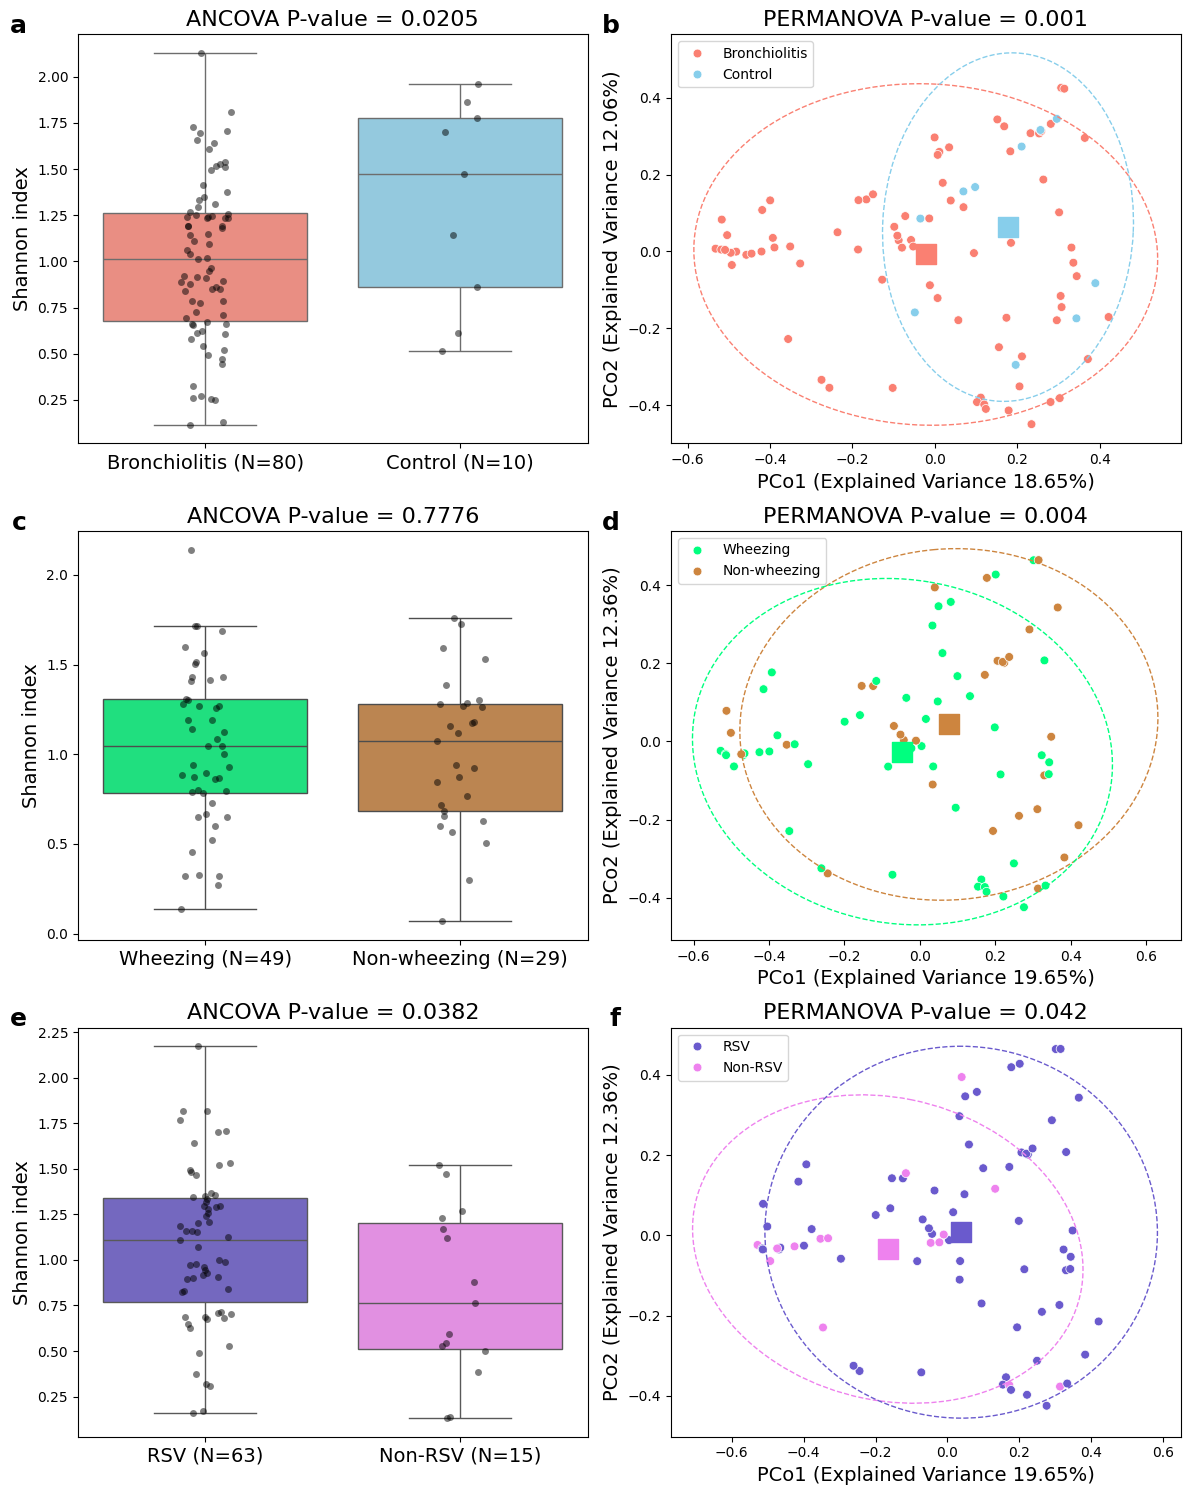

In [302]:
bql_anf.calc_beta_div()
bql_anf.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_ANF.csv")

bql_anf_brq.calc_beta_div()
bql_anf_brq.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_ANF_BRQ.csv")


fig,axS = plt.subplots(3,2,figsize=(12,15))

axS = axS.flatten()
# Start with the Fig 2 B , beta div
palette = {"Bronchiolitis":"salmon","Control":"Skyblue"}
bql_anf.adata.obs["Bronchiolitis"]= bql_anf.adata.obs["Bronchiolitis"].replace({"Yes":"Bronchiolitis","No":"Control"})


df = bql_anf.find_var(['Shannon_index_level_Genus','Bronchiolitis',  "Respiratory syncytial virus",
                       "Wheezing treatment",'Family history atopy','Breastfeeding', 'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=6, plot=True,  ax=axS[0], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Bronchiolitis (N=80)","Control (N=10)"],fontsize=14)


# Start with the Fig 1 B , beta div
bql_anf.plot_pcoa(obsm_key="PCoA",condition_name="Bronchiolitis",show=False,exp_var=bql_anf.adata.uns["PCoA_exp_var"],
               ax=axS[1],palette=palette)

axS[1].set_title(f"PERMANOVA P-value = 0.001", fontsize=16)
axS[1].set_xlabel(axS[1].get_xlabel(), fontsize=14)
axS[1].set_ylabel(axS[1].get_ylabel(), fontsize=14)
axS[1].legend()

# Add annotations for subplots
axS[0].text(-0.1, 1.05, "a", transform=axS[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[1].text(-0.1, 1.05, "b", transform=axS[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

###################

# FIGURAS 2.C Y 2. D 

###################


# Start with the Fig 2 B , beta div
palette = {"Wheezing":"springgreen","Non-wheezing":"peru"}
bql_anf_brq.adata.obs["Wheezing treatment"]= bql_anf_brq.adata.obs["Wheezing treatment"].replace({"Yes":"Wheezing","No":"Non-wheezing"})


df = bql_anf_brq.find_var(['Shannon_index_level_Genus', "Wheezing treatment",  "Respiratory syncytial virus",
                      'Family history atopy','Breastfeeding', 'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=5, plot=True,  ax=axS[2], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Wheezing (N=49)","Non-wheezing (N=29)"],fontsize=14)


# Start with the Fig 1 B , beta div
bql_anf_brq.plot_pcoa(obsm_key="PCoA",condition_name="Wheezing treatment",show=False,exp_var=bql_anf_brq.adata.uns["PCoA_exp_var"],
               ax=axS[3],palette=palette)

axS[3].set_title(f"PERMANOVA P-value = 0.004", fontsize=16)
axS[3].set_xlabel(axS[3].get_xlabel(), fontsize=14)
axS[3].set_ylabel(axS[3].get_ylabel(), fontsize=14)
axS[3].legend()

# Add annotations for subplots
axS[2].text(-0.1, 1.05, "c", transform=axS[2].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[3].text(-0.1, 1.05, "d", transform=axS[3].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

###################

# FIGURAS 2.E Y 2. F 

###################


# Start with the Fig 2 B , beta div
palette = {"RSV":"slateblue","Non-RSV":"violet"}
bql_anf_brq.adata.obs["Respiratory syncytial virus"]= bql_anf_brq.adata.obs["Respiratory syncytial virus"].replace({"Yes":"RSV","No":"Non-RSV"})


df = bql_anf_brq.find_var(['Shannon_index_level_Genus', "Respiratory syncytial virus",  "Wheezing treatment",
                      'Family history atopy','Breastfeeding', 'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=5, plot=True,  ax=axS[4], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["RSV (N=63)","Non-RSV (N=15)"],fontsize=14)

# Start with the Fig 1 B , beta div
bql_anf_brq.plot_pcoa(obsm_key="PCoA",condition_name="Respiratory syncytial virus",show=False,exp_var=bql_anf_brq.adata.uns["PCoA_exp_var"],
               ax=axS[5],palette=palette)

axS[5].set_title(f"PERMANOVA P-value = 0.042", fontsize=16)
axS[5].set_xlabel(axS[5].get_xlabel(), fontsize=14)
axS[5].set_ylabel(axS[5].get_ylabel(), fontsize=14)
axS[5].legend()

# Add annotations for subplots
axS[4].text(-0.1, 1.05, "e", transform=axS[4].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[5].text(-0.1, 1.05, "f", transform=axS[5].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')



plt.savefig("Figures/FIGURE_2.svg", bbox_inches="tight")
plt.show()

# Figure 3

Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix
Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix


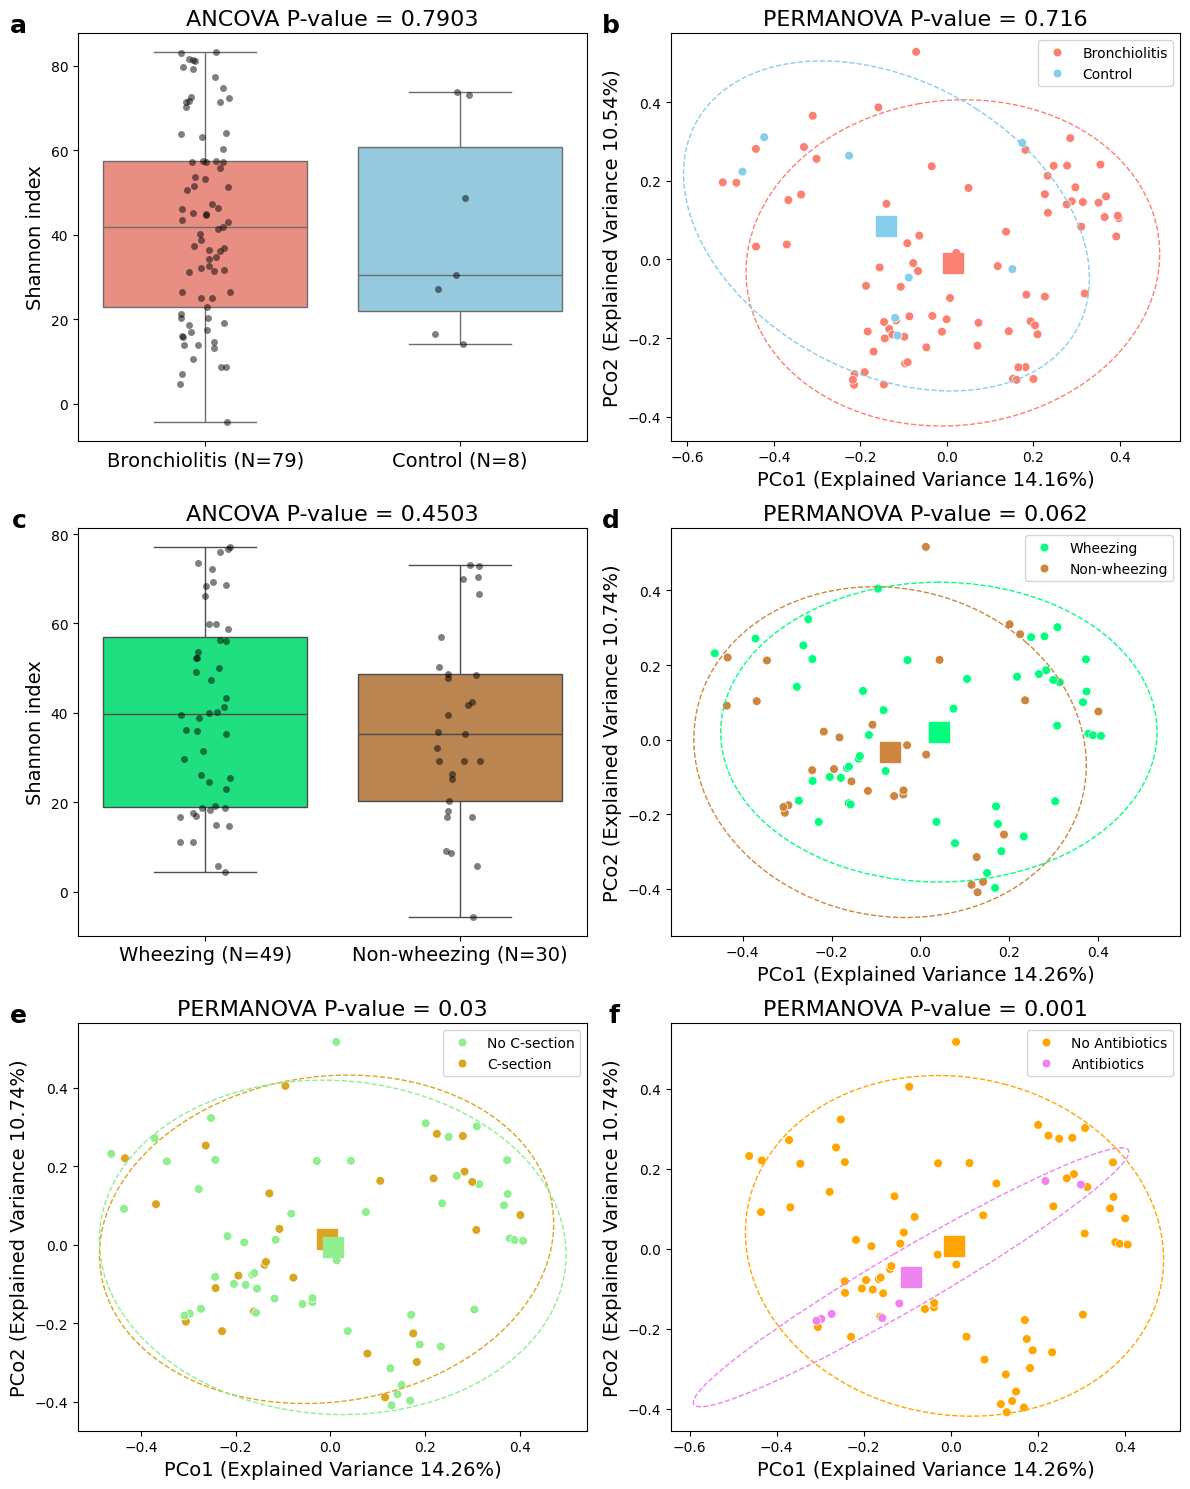

In [303]:
bql_gut.calc_beta_div()
bql_gut.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_GUT.csv")

bql_gut_brq.calc_beta_div()
bql_gut_brq.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_GUT_BRQ.csv")


fig,axS = plt.subplots(3,2,figsize=(12,15))
axS = axS.flatten()

# Start with the Fig 2 B , beta div
palette = {"Bronchiolitis":"salmon","Control":"Skyblue"}
bql_gut.adata.obs["Bronchiolitis"]= bql_gut.adata.obs["Bronchiolitis"].replace({"Yes":"Bronchiolitis","No":"Control"})


df = bql_gut.find_var(['Shannon_index_level_Genus','Bronchiolitis',  "Respiratory syncytial virus",
                       "Wheezing treatment",'Family history atopy','Breastfeeding', 'Cesarean section',"Previous antibiotics",'Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=7, plot=True,  ax=axS[0], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Bronchiolitis (N=79)","Control (N=8)"],fontsize=14)

# Start with the Fig 1 B , beta div
bql_gut.plot_pcoa(obsm_key="PCoA",condition_name="Bronchiolitis",show=False,exp_var=bql_gut.adata.uns["PCoA_exp_var"],
               ax=axS[1],palette=palette)

axS[1].set_title(f"PERMANOVA P-value = 0.716", fontsize=16)
axS[1].set_xlabel(axS[1].get_xlabel(), fontsize=14)
axS[1].set_ylabel(axS[1].get_ylabel(), fontsize=14)
axS[1].legend()

# Add annotations for subplots
axS[0].text(-0.1, 1.05, "a", transform=axS[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[1].text(-0.1, 1.05, "b", transform=axS[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')



###################

# FIGURAS 3.C Y 3.D 

###################



# Start with the Fig 2 B , beta div
palette = {"Wheezing":"springgreen","Non-wheezing":"peru"}
bql_gut_brq.adata.obs["Wheezing treatment"]= bql_gut_brq.adata.obs["Wheezing treatment"].replace({"Yes":"Wheezing","No":"Non-wheezing"})


df = bql_gut_brq.find_var(['Shannon_index_level_Genus', "Wheezing treatment",  "Respiratory syncytial virus",
                      'Family history atopy','Breastfeeding', "Previous antibiotics",'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=6, plot=True,  ax=axS[2], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Wheezing (N=49)","Non-wheezing (N=30)"],fontsize=14)

# Start with the Fig 1 B , beta div
bql_gut_brq.plot_pcoa(obsm_key="PCoA",condition_name="Wheezing treatment",show=False,exp_var=bql_gut_brq.adata.uns["PCoA_exp_var"],
               ax=axS[3],palette=palette)

axS[3].set_title(f"PERMANOVA P-value = 0.062", fontsize=16)
axS[3].set_xlabel(axS[3].get_xlabel(), fontsize=14)
axS[3].set_ylabel(axS[3].get_ylabel(), fontsize=14)
axS[3].legend()

# Add annotations for subplots
axS[2].text(-0.1, 1.05, "c", transform=axS[2].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[3].text(-0.1, 1.05, "d", transform=axS[3].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')




###################

# FIGURAS 3.E Y 3.F 

###################


# Start with the Fig 2 B , beta div
palette = {"Antibiotics":"violet","No Antibiotics":"orange"}
bql_gut_brq.adata.obs["Previous antibiotics"]= bql_gut_brq.adata.obs["Previous antibiotics"].replace({"Yes":"Antibiotics","No":"No Antibiotics"})

palette_2 = {"C-section":"goldenrod","No C-section":"lightgreen"}

bql_gut_brq.adata.obs["Cesarean section"]= bql_gut_brq.adata.obs["Cesarean section"].replace({"Yes":"C-section","No":"No C-section"})

# Start with the Fig 1 B , beta div
bql_gut_brq.plot_pcoa(obsm_key="PCoA",condition_name="Cesarean section",show=False,exp_var=bql_gut_brq.adata.uns["PCoA_exp_var"],
               ax=axS[4],palette=palette_2)

axS[4].set_title(f"PERMANOVA P-value = 0.03", fontsize=16)
axS[4].set_xlabel(axS[4].get_xlabel(), fontsize=14)
axS[4].set_ylabel(axS[4].get_ylabel(), fontsize=14)
axS[4].legend()

# Start with the Fig 1 B , beta div
bql_gut_brq.plot_pcoa(obsm_key="PCoA",condition_name="Previous antibiotics",show=False,exp_var=bql_gut_brq.adata.uns["PCoA_exp_var"],
               ax=axS[5],palette=palette)

axS[5].set_title(f"PERMANOVA P-value = 0.001", fontsize=16)
axS[5].set_xlabel(axS[5].get_xlabel(), fontsize=14)
axS[5].set_ylabel(axS[5].get_ylabel(), fontsize=14)
axS[5].legend()

# Add annotations for subplots
axS[4].text(-0.1, 1.05, "e", transform=axS[4].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[5].text(-0.1, 1.05, "f", transform=axS[5].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')



plt.savefig("Figures/FIGURE_3.svg", bbox_inches="tight")
plt.show()

# Figure 4

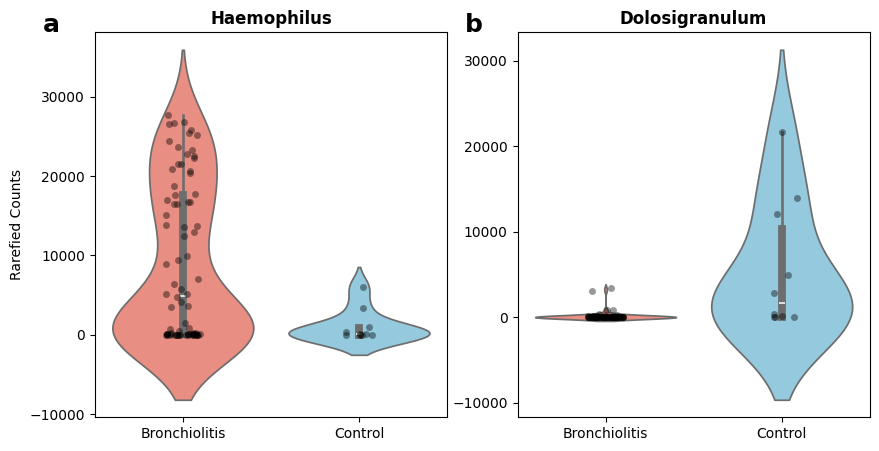

In [304]:
df_genus = pd.DataFrame(bql_anf.adata.X,index=bql_anf.adata.obs_names,columns=bql_anf.adata.var.Genus)

# Extract dataframes with the bacterial genus counts
haemophilus=df_genus["Haemophilus"].sum(axis=1).to_frame().rename(columns={0:"Haemophilus"})
haemophilus["Bronchiolitis"] = haemophilus.index.map(bql_anf.adata.obs.Bronchiolitis.to_dict())
haemophilus["Bronchiolitis"].replace({"Yes":"Bronchiolitis", "No":"Control"},inplace=True)

dolosigranulum=df_genus["Dolosigranulum"].sum(axis=1).to_frame().rename(columns={0:"Dolosigranulum"})
dolosigranulum["Bronchiolitis"] = dolosigranulum.index.map(bql_anf.adata.obs.Bronchiolitis.to_dict())
dolosigranulum["Bronchiolitis"].replace({"Yes":"Bronchiolitis", "No":"Control"},inplace=True)

fig,axs= plt.subplots(1,2,figsize=(10,5))
# Define the palette
palette={"Bronchiolitis": "salmon", "Control": "skyblue"}


# PLot haemophilus
sns.violinplot(
        data=haemophilus,
        y="Haemophilus",
        x="Bronchiolitis",     
        palette=palette,ax=axs[0])

sns.stripplot(
        data=haemophilus,
        y="Haemophilus",
        x="Bronchiolitis",  color="black" ,alpha=0.4 ,ax=axs[0])

axs[0].set_xlabel("")
axs[0].set_ylabel("Rarefied Counts")
axs[0].set_title("Haemophilus",fontweight=900)


# Plot Dolosigranulum
sns.violinplot(
        data=dolosigranulum,
        y="Dolosigranulum",
        x="Bronchiolitis",     
        palette=palette,ax=axs[1])

sns.stripplot(
        data=dolosigranulum,
        y="Dolosigranulum",
        x="Bronchiolitis",  color="black" ,alpha=0.4 ,ax=axs[1])

axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_title("Dolosigranulum",fontweight=900)

# Add annotations for subplots
axs[0].text(-0.1, 1.05, "a", transform=axs[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axs[1].text(-0.1, 1.05, "b", transform=axs[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

plt.savefig("Figures/Figure_4.svg")
plt.show()

#  PREPROCESS DATA FOR WGCNA:

- Metadata variables were codified into numeric binary categories for the WGCNA analysis.

- The rarefied count data was normalized by the centered log ratio method


In [305]:
os.makedirs("WGCNA",exist_ok=True)
os.makedirs("WGCNA/data",exist_ok=True)

# Formatting and saving ANF data
meta_anf = bql_anf.adata.obs[["Bronchiolitis",	
                  'Wheezing treatment',	
                  'Respiratory syncytial virus',	
                  'Cesarean section',
                  'Previous antibiotics',
                  'Age_older',
                  'Family history atopy',
                  'Breastfeeding']].replace({"Yes":1,
                                             "No":0,
                                             "Bronchiolitis":1,
                                             "Control":0}).dropna()
meta_anf.to_csv("WGCNA/data/ANF_BQL_metadata.csv")


# Formatting and saving GUT data
meta_gut = bql_gut.adata.obs[["Bronchiolitis",	
                  'Wheezing treatment',	
                  'Respiratory syncytial virus',	
                  'Cesarean section',
                  'Previous antibiotics',
                  'Age_older',
                  'Family history atopy',
                  'Breastfeeding']].replace({"Yes":1,
                                             "No":0,
                                             "Bronchiolitis":1,
                                             "Control":0}).dropna()
meta_gut.to_csv("WGCNA/data/GUT_BQL_metadata.csv")

### COUNT DATA NORMALIZING

In [306]:
def relab(row):
    row1 = row.copy()
    total= row1.sum()
    row1[row1!=0] = row1[row1!=0] / total
    return row1

In [307]:
# Extract the rarefied data
df_anf = bql_anf.adata.to_df().loc[meta_anf.index]

# Add the genus label
df_anf.loc["Genus"] = bql_anf.adata.var.Genus

# Aggregate the data by Genus
df_anf = df_anf.T.dropna(subset="Genus").groupby("Genus").sum().T

# Filter out the unassigned genus
df_anf = df_anf[df_anf.columns[df_anf.columns.str.contains("unidentif")==False]].T


# This column selects those taxa that appears in at leat th 5% of the samples (will be relevat for networks) 5
df_anf["MIN_SAMPLE_CRITERIA"] = [(df_anf.loc[ind]>0).sum()>5 for ind in df_anf.index]
# This column selects taxa with an abundance above the 10% quantile along all samples
df_anf["Min_Counts_criteria"] = df_anf.sum(axis=1)>df_anf.sum(axis=1).quantile(0.1)
# Filter and transpose the data
df_anf = df_anf[(df_anf.Min_Counts_criteria)&(df_anf.MIN_SAMPLE_CRITERIA)].drop(["MIN_SAMPLE_CRITERIA","Min_Counts_criteria"],axis=1).T



rel_anf = df_anf.apply(relab,axis=1)
pseudocount = rel_anf[rel_anf>0].min().min()/100

# Transform the data into numpy arrays
data_clr = rel_anf.to_numpy(float)

data_clr += pseudocount

# Compute geometric mean across rows
geometric_mean = np.exp(np.mean(np.log(data_clr), axis=1, keepdims=True))

# Apply CLR transformation
clr_transformed = np.log(data_clr / geometric_mean)

clr_transformed = pd.DataFrame(clr_transformed,columns=df_anf.columns,index=df_anf.index)

clr_transformed.to_csv("WGCNA/data/ANF_BQL_counts.csv")

clr_transformed

Genus,Acetoanaerobium,Acetobacteroides,Acidibacter,Acidovorax,Acinetobacter,Actinobacillus,Actinomyces,Aeromonas,Agathobacter,Aggregatibacter,...,Treponema,Trichococcus,UCG-005,Uruburuella,Veillonella,Zoogloea,[Eubacterium]_hallii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,dgA-11_gut_group
BQLHLP100ANF,4.107680,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,...,-1.196871,-1.196871,-1.196871,-1.196871,8.640714,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871
BQLHLP101ANF,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,...,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877
BQLHLP103ANF,-1.795517,-1.795517,-1.795517,-1.795517,-1.795517,-1.795517,10.507877,-1.795517,-1.795517,-1.795517,...,-1.795517,4.430377,2.828818,-1.795517,9.429669,-1.795517,-1.795517,-1.795517,2.828818,-1.795517
BQLHLP104ANF,-1.514088,-1.514088,-1.514088,4.806125,4.806125,-1.514088,10.904647,-1.514088,-1.514088,-1.514088,...,-1.514088,-1.514088,-1.514088,-1.514088,11.202922,-1.514088,-1.514088,-1.514088,-1.514088,-1.514088
BQLHLP105ANF,0.957770,-4.757572,-4.757572,3.075130,3.845025,-4.757572,3.863371,2.900852,1.649268,-4.757572,...,0.957770,3.439652,1.244628,-4.757572,5.572918,0.553951,0.957770,0.957770,1.244628,1.803183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HULP67ANF,2.941677,-3.865873,1.845273,3.452060,4.407163,-3.865873,-3.865873,3.142147,2.132128,-3.865873,...,-3.865873,3.921815,1.441461,1.845273,2.132128,-3.865873,-3.865873,-3.865873,0.753257,2.132128
HULP68ANF,-4.463793,-4.463793,2.798925,3.625209,4.938372,-4.463793,2.462733,3.378435,-4.463793,-4.463793,...,3.104122,4.601933,2.106478,2.357481,2.462733,2.106478,-4.463793,-4.463793,1.770567,2.106478
HULP69ANF,-1.624416,-1.624416,4.377712,-1.624416,-1.624416,5.985169,-1.624416,-1.624416,-1.624416,-1.624416,...,2.998811,-1.624416,-1.624416,-1.624416,6.652757,-1.624416,-1.624416,-1.624416,-1.624416,-1.624416
HULP70ANF,1.971955,-3.340646,4.962993,4.107662,5.704801,2.375775,1.283724,3.472191,2.885284,-3.340646,...,2.885284,-3.340646,2.662634,-3.340646,-3.340646,2.662634,1.971955,-3.340646,-3.340646,2.375775


## Now the BQL GUT data

In [308]:
# Extract the rarefied data
df_gut = bql_gut.adata.to_df().loc[meta_gut.index]

# Add the genus label
df_gut.loc["Genus"] = bql_gut.adata.var.Genus

# Aggregate the data by Genus
df_gut = df_gut.T.dropna(subset="Genus").groupby("Genus").sum().T

# Filter out the unassigned genus
df_gut = df_gut[df_gut.columns[df_gut.columns.str.contains("unidentif")==False]].T


# This column selects those taxa that appears in at leat th 5% of the samples (will be relevat for networks)
df_gut["MIN_SAMPLE_CRITERIA"] = [(df_gut.loc[ind]>0).sum()>4 for ind in df_gut.index]
# This column selects taxa with an abundance above the 10% quantile along all samples
df_gut["Min_Counts_criteria"] = df_gut.sum(axis=1)>df_gut.sum(axis=1).quantile(0.1)
# Filter and transpose the data
df_gut = df_gut[(df_gut.Min_Counts_criteria)&(df_gut.MIN_SAMPLE_CRITERIA)].drop(["MIN_SAMPLE_CRITERIA","Min_Counts_criteria"],axis=1).T



rel_gut = df_gut.apply(relab,axis=1)
pseudocount = rel_gut[rel_gut>0].min().min()/100
# Transform the data into numpy arrays
data_clr = rel_gut.to_numpy(float)

data_clr += pseudocount

# Compute geometric mean across rows
geometric_mean = np.exp(np.mean(np.log(data_clr), axis=1, keepdims=True))

# Apply CLR transformation
clr_transformed = np.log(data_clr / geometric_mean)

clr_transformed = pd.DataFrame(clr_transformed,columns=df_gut.columns,index=df_gut.index)

clr_transformed.to_csv("WGCNA/data/GUT_BQL_counts.csv")

